## Weather Identification Modelling

### Project Description
This project attempts to train a model to predict the weather ocurring in a given image. Using a database from Mendely Data at https://data.mendeley.com/datasets/4drtyfjtfy/1, 1117 pictures of weather were analyzed here. The data consists of weather labelled 'cloudy', 'rain', 'shine', and 'sunrise'. One model uses a k-Nearest Neighbors classification algorithm to determine the images in the test dataset that are most alike to the test image, and gives the test image the label most commonly used by those neighbors. The second model uses Support Vector Classification to create a hyperplane boundary between each category in a many dimensional space, with new images being placed in this space and given the category defined by the boundaries around that point. These models were chosen for their ability to categorize data into multiple labels, as well as a glance at the images in question showed distinct differences to the human eye between categories. Models like these could be used by meteorologists to determine the current weather across many different locations quickly, if the model is accurate enough.

#### Data
The initial data consists of almost entirely .jpg images, with some .jpeg images and some .png images. The usable images were converted into a list of the RGB values for each pixel, beginning in the top left corner and ending in the bottom right. Then this array was converted into a 1-dimensional array consisting of [R1, G1, B1, R2, G2, B2...] and so on. The images however were of different dimensions, so before the arrays could be generated, each image was resized to share the minimum dimensions across the dataset, which were found to be 94 pixels across and 159 pixels tall. The images used RGB color channels to better convey what weather looks like more accurately. Some weather uses different colors than others, and greyscale images would lose this insight, likely causing a reduction in model accuracy.

### Data Cleaning
The .png images were removed from the data in this project as the pixel information was incompatible, and they were a relatively small portion of the dataset. Each pixel of the .jpg and .jpeg images had three values, one for each RGB channel. The .png images produced only one value. Even still, the remaining images were of different dimensions, so before the arrays could be generated, each image was resized to share the minimum dimensions across the dataset, which were found to be 94 pixels across and 159 pixels tall.

#### Importing Packages

In [24]:
from PIL import Image
import glob
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt            
from sklearn.svm import SVC                                
from sklearn.model_selection import train_test_split   
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.utils import shuffle

#### Reading In Images to Numpy Array
##### Creating Additional Array for Use in Generating a Label Vector

In [25]:
image_list = []
name_list = []
for filename in glob.glob('dataset2/*.jpg'):
    im=Image.open(filename, 'r')
    name=os.path.basename(filename)
    im = im.resize((158, 94))
    image_list.append(np.asarray(im))
    name_list.append(name)

##### Obsolete Code Used to Find Minimum Image Dimensions, Applied Above

In [26]:
#xs = []
#ys = []
#for i in image_list:
    #xs.append(i.shape[0])
    #ys.append(i.shape[1])
#print(min(xs), min(ys))
#for i in image_list:
    #print(i.shape)

In [27]:
print(len(image_list))
print(len(name_list))

1117
1117


### EDA: Balance of Labels
Here I create the label vector 'classification' and check to make sure there is an even-enough distribution of labels to continue. All four categories show over 200 images, which should be enough to have a strong sample size for each category.

<AxesSubplot: >

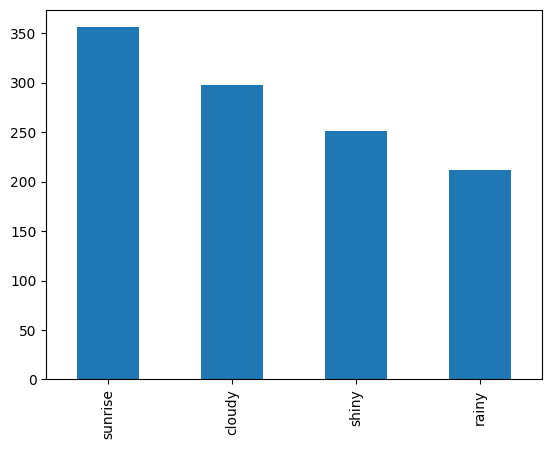

In [28]:
classification = []
for i in name_list:
    if 'cloudy' in i:
        classification.append('cloudy')
    elif 'rain' in i:
        classification.append('rainy')
    elif 'shine' in i:
        classification.append('shiny')
    elif 'sunrise' in i:
        classification.append('sunrise')
pd.Series(classification).value_counts().plot(kind='bar')

##### Flattening the Array
This flattens each image array into one single-dimensional array of length width x height x depth, so that each picture can be one observation in our dataframe.

In [29]:
colCount = image_list[0].shape[0] * image_list[0].shape[1] * 3
for i in range(len(image_list)):
    image_list[i] = np.ndarray.flatten(image_list[i]).reshape(colCount, 1)
image_list = np.dstack(image_list)
image_list = np.rollaxis(image_list, axis = 2, start = 0)
image_list = image_list.reshape(len(classification), colCount)

##### Creation of Dataframe
The dataframe is created with the label vector added as the final column. Then the data is shuffled, and the y values are set to the final column, with the x values set to everything else.

In [30]:
data = pd.DataFrame(image_list)
data['label'] = classification
print(data)

        0    1    2    3    4    5    6    7    8    9  ...  44547  44548  \
0     128  128  128  133  133  133  134  134  134  136  ...     53     53   
1     169  184  215  165  180  211  169  184  215  167  ...    117    147   
2     137  137  149  141  144  157  145  148  164  143  ...     92     78   
3     212  209  216  212  209  216  213  210  217  214  ...     20     13   
4      81   96  126   80   94  125   77   91  121   76  ...     86     95   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
1112  131   77   16  135   77   18  138   80   16  139  ...      1      1   
1113  135   14    1  140   15    1  142   17    1  145  ...     22      2   
1114    0    0    0    0    0    0    0    0    0    0  ...      0      0   
1115  111   37   11  111   37   11  111   37   11  111  ...     47     27   
1116  146   71   31  146   71   32  149   72   33  152  ...     57     32   

      44549  44550  44551  44552  44553  44554  44555    label  
0        5

In [31]:
shfl = shuffle(data).reset_index()
shfl = shfl.drop(['index'], axis = 1)
shfl
x = shfl.values[:, :-1]
y = shfl.values[:, -1]

#### The First Model
This is the k-Nearest Neighbors model. It utilizes up to 10 KFold splits and up to 5 neighbors when creating a model for each combination of split count and neighbor count. The best model's accuracy score is returned, along with its parameters.

In [32]:
bestScore = 0
bestNeighb = 0
bestSplit = 0
c = 0
kf = KFold(n_splits = 10)
for train, test in kf.split(x):
    c += 1
    x_train, x_test = x[train], x[test]
    y_train, y_test = y[train], y[test]
    for k in range(1, 6):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)
        score = metrics.accuracy_score(y_test, knn.predict(x_test))
        if score > bestScore:
            bestScore = score
            bestNeighb = k
            bestSplit = c
    print(str(int((c/10) * 100))+"% complete.")
print("The best model returned an accuracy score of " + str(bestScore) + " with " + str(bestNeighb) + " neighbor(s) and " + str(bestSplit) + " K-Fold split(s).")

10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.
The best model returned an accuracy score of 0.9017857142857143 with 1 neighbor(s) and 3 K-Fold split(s).


#### The Second Model
This is the Support Vector Machine model. First the data is split with 80% being allocated for the training set and 20% allocated for the test set. The model is created with the default parameters of C = 1.0 and kernel = 'rbf'. This is due to the long wait times for any hyperparameter tuning, even after additional cache was allocated for the test and the model was reduced to a linear prediction. The accuracy score and parameters are produced below.

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0, test_size = 0.2)
svc = SVC(probability=True)

In [34]:
svc.fit(x_train, y_train)

SVC(probability=True)

In [35]:
ysvc_pred = svc.predict(x_test)
print("The SVC model with parameters C = 1.0 and kernel = rbf returned an accuracy score of: " + str(metrics.accuracy_score(ysvc_pred, y_test)))

The SVC model with parameters C = 1.0 and kernel = rbf returned an accuracy score of: 0.8794642857142857


### Results and Analysis
The best k-Nearest Neighbors model returned an accuracy score slightly higher than that of the SVC model (~90% to ~88%, with some variation). However, this is likely due to the hyperparameter tuning and resampling methods included during the genisis of that model. The SVC model, while slightly lower scoring, could not utilize hyperparameter tuning or resampling due to the seemingly never-ending modelling duration. Given better resources or smaller images, and therefore fewer features, the SVC model could be found to produce even higher accuracy scores with different parameters. As to those hyperparameters and resampling methods, the best k-NN model utilized one neighbor and 5 K-Fold splits. I find it interesting that only one neighbor is the most accurate model. The complexity of the model decreases as k increases, so there may be some overfitting of the data. However, the resampling with 5 splits likely counterracts this increase in bias a bit. I had first intended to use this hyperparameter tuning and resampling using sklearn's GridSearchCV, but even with a few values given to C and gamma the code took over 10 minutes to run, and at that point I stopped the kernel. I had allocated extra ram for the cache and attempted a linear svm kernel to no avail. However, finding the best parameters would likely benefit this model significantly. Either way, both models produced strong results. Given low processing power, I would opt to use the k-NN model, but with infinite resources I would tune and use the SVM model.

### Conclusion
An easy, if not quick, way to improve on this project would be to include hyperparamater tuning and resampling for the SVM model. This may require stronger computational power, a reformatting of the data to have fewer features, or just more patience. The use of the .png files included in the dataset did not work because, when converted to a numpy array, each pixel entry only had 1 value, whereas the .jpg images, the vast majority, had 3 values, one for each color channel. Because of this, when the arrays were flattened into usable vectors the .png vectors were shorter, and thus could not be compared in the model to the longer arrays created from the .jpg and .jpeg images. Some important takeaways from this project were the use of KFold and the impact that it has on accuracy. Before this project I did not recognize the term, but after searching for a way to improve my project (thank you Maaz), I did research on, and learned to understand, KFold-ing. The use of this technique increased the accuracy of the k-NN model by nearly 20%, a huge jump that I was not expecting, but am grateful for nonetheless.

#### Data Reference
Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1